In [1]:
# Importing Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Imorting ML Preprocessing and Metrics Libraries
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    Normalizer,
    RobustScaler,
    LabelEncoder,
    OneHotEncoder,
)

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# Importing Classifiers
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Some Extra Libraries
import warnings as w
w.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [2]:
train = pd.read_csv(r"../Data/train.csv")
test = pd.read_csv(r"../Data/test.csv")
original = pd.read_csv(r"../Data/original_data.csv")

#### The following columns can be omitted because their values do not affect the analysis results
1. `Over18`: All values are `Y`
2. `EmployeeCount`: all values are `1.0`
3. `StandardHours`: all values are `80.0`
4. `EmployeeNumber`: is the `id` of the employee that has the same meaning as the `index` of each line
5. 'EmployeeCount': all values are `1.0`

In [3]:
att = {"Yes": 1, "No": 0}


def drop_cols(df):
    if df is train:
        df = df.drop(columns=["id", "Over18", "StandardHours", "EmployeeCount"])
    elif df is test:
        df = df.drop(columns=["Over18", "StandardHours", "EmployeeCount"])
    else:
        df["Attrition"] = df["Attrition"].map(att)
        df = df.drop(
            columns=["EmployeeNumber", "Over18", "StandardHours", "EmployeeCount"]
        )
    return df


original = drop_cols(original)
train = drop_cols(train)
test = drop_cols(test)

# Rectifying the anamolies in the training data according to the original data

In [4]:
# # Repalcing the outliers.
train[train["Education"] == 15]
train[train["JobLevel"] == 7]
train.at[527, "Education"] = 5
train.at[1535, "JobLevel"] = 5

In [5]:
# Finding numrical Columns using the unique values.

num_cols = [col for col in train.columns if train[col].nunique() > 20]
num_cols

['Age',
 'DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'TotalWorkingYears',
 'YearsAtCompany']

In [6]:
# Converting the outliers in the numreic columns to the median.

for col in num_cols:
    if train[col].dtype != "object":
        train[col] = np.where(
            train[col] > train[col].quantile(0.95),
            train[col].median(),
            train[col],
        )
        train[col] = np.where(
            train[col] < train[col].quantile(0.05),
            train[col].median(),
            train[col],
        )
        pass
    else:
        pass
    
for col in num_cols:
    if original[col].dtype != "object":
        original[col] = np.where(
            original[col] > original[col].quantile(0.95),
            original[col].median(),
            original[col],
        )
        original[col] = np.where(
            original[col] < original[col].quantile(0.05),
            original[col].median(),
            original[col],
        )
        pass
    else:
        pass

In [7]:
# Concatenating the train and original data.
train = pd.concat([train, original], axis=0).reset_index(drop=True)
train.drop_duplicates(inplace=True)

In [8]:
train.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36.000,Travel_Frequently,599.000,Research & Development,24.000,3,Medical,4,Male,42.000,3,1,Laboratory Technician,4,Married,2596.000,5099.000,1,Yes,13,3,2,1,10.000,2,3,10.000,0,7,8,0
1,35.000,Travel_Rarely,921.000,Sales,8.000,3,Other,1,Male,46.000,3,1,Sales Representative,1,Married,2899.000,10778.000,1,No,17,3,4,1,4.000,3,3,4.000,2,0,3,0
2,32.000,Travel_Rarely,718.000,Sales,26.000,3,Marketing,3,Male,80.000,3,2,Sales Executive,4,Divorced,4627.000,16495.000,0,No,17,3,4,2,4.000,3,3,3.000,2,1,2,0
3,38.000,Travel_Rarely,890.000,Research & Development,2.000,3,Medical,3,Female,40.000,3,2,Healthcare Representative,1,Married,5347.000,13384.000,3,No,14,3,3,0,15.000,1,1,6.000,0,0,2,0
4,50.000,Travel_Rarely,1017.000,Research & Development,5.000,4,Medical,2,Female,37.000,3,5,Manager,1,Single,4834.000,19805.000,1,Yes,13,3,3,0,9.000,0,3,5.000,14,4,10,1


Numerical Value - Age, DailyRate, DistanceFromHome, HourlyRate, MonthlyIncome, MonthlyRate, NumCompaniesWorked, PercentSalaryHike, TotalWorkingYears, TrainingTimesLastYear, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager

# Feature Engineering

- ### Creating a new feature name risk_factor which takes in count for condition of the employee to leave or stay.
- ### Creating a new feature like dedication, jobskill, satisfaction, MonthlyRateIncome, DailyHoulryRate of Employee

In [9]:
def feature_engineering(df):
    df["risk_factors"] = df[
        [
            "RelationshipSatisfaction",
            "MonthlyIncome",
            "BusinessTravel",
            "Department",
            "EducationField",
            "Education",
            "JobInvolvement",
            "JobSatisfaction",
            "RelationshipSatisfaction",
            "StockOptionLevel",
            "TrainingTimesLastYear",
            "WorkLifeBalance",
            "OverTime",
        ]
    ].apply(
        lambda x: 0
        + (1 if x.MonthlyIncome < 3000 else 0)
        + (1 if x.BusinessTravel == "Travel_Frequently" else 0)
        + (1 if x.Department == "Human Resources" else 0)
        + (1 if x.EducationField in ["Human Resources", "Marketing"] else 0)
        + (1 if x.Education == 1 else 0)
        + (1 if x.JobInvolvement == 1 else 0)
        + (1 if x.JobSatisfaction == 1 else 0)
        + (1 if x.StockOptionLevel == 0 else 0)
        + (1 if x.TrainingTimesLastYear == 0 else 0)
        + (1 if x.WorkLifeBalance == 1 else 0)
        + (1 if x.OverTime == 1 else 0),
        axis=1,
    )

    df["Dedication"] = (
        df["YearsAtCompany"] + df["YearsInCurrentRole"] + df["TotalWorkingYears"]
    )
    df["JobSkill"] = df["JobInvolvement"] * df["JobLevel"]
    df["Satisfaction"] = df["EnvironmentSatisfaction"] * df["RelationshipSatisfaction"]
    df["MonthlyRateIncome"] = df["MonthlyIncome"] * df["MonthlyRate"]
    df["HourlyDailyRate"] = df["HourlyRate"] * df["DailyRate"]

    return df


train = feature_engineering(train)
test = feature_engineering(test)

In [10]:
le = LabelEncoder()

le_cols = ["Gender", "OverTime", "MaritalStatus", "PerformanceRating"]
ohe_cols = [
    "Department",
    "BusinessTravel",
]
map_cols = ["EducationField", "JobRole"]


def encode_labels(df, cols):
    for col in cols:
        df[col] = le.fit_transform(df[col])
    return df


def ohe_labels(df, cols):
    df = pd.get_dummies(df, columns=ohe_cols,dtype=int)
    return df

def map_labels(df, map_cols):
    for col in map_cols:
        if col == "EducationField":
            df[col] = df[col].map(
                {
                    "Life Sciences": 1,
                    "Medical": 2,
                    "Marketing": 3,
                    "Technical Degree": 4,
                    "Human Resources": 5,
                    "Other": 6,
                }
            )
        elif col == "JobRole":
            df[col] = df[col].map(
                {
                    "Sales Executive": 1,
                    "Research Scientist": 2,
                    "Laboratory Technician": 3,
                    "Manufacturing Director": 4,
                    "Healthcare Representative": 5,
                    "Manager": 6,
                    "Sales Representative": 7,
                    "Research Director": 8,
                    "Human Resources": 9,
                }
            )
    return df

train = map_labels(train, map_cols)
test = map_labels(test, map_cols)

train = encode_labels(train, le_cols)
test = encode_labels(test, le_cols)

train = ohe_labels(train, ohe_cols)
test = ohe_labels(test, ohe_cols)

In [11]:
for i in train.columns:
    print(i, train[i].nunique(), train[i].max(), train[i].min())

Age 31 54.0 24.0
DailyRate 818 1443.0 167.0
DistanceFromHome 26 26.0 1.0
Education 5 5 1
EducationField 6 6 1
EnvironmentSatisfaction 4 4 1
Gender 2 1 0
HourlyRate 65 97.0 33.0
JobInvolvement 4 4 1
JobLevel 5 5 1
JobRole 9 9 1
JobSatisfaction 4 4 1
MaritalStatus 3 2 0
MonthlyIncome 1242 17779.0 2096.0
MonthlyRate 1311 25761.0 3395.0
NumCompaniesWorked 10 9 0
OverTime 2 1 0
PercentSalaryHike 15 25 11
PerformanceRating 2 1 0
RelationshipSatisfaction 4 4 1
StockOptionLevel 4 3 0
TotalWorkingYears 28 28.0 1.0
TrainingTimesLastYear 7 6 0
WorkLifeBalance 4 4 1
YearsAtCompany 20 20.0 1.0
YearsInCurrentRole 19 18 0
YearsSinceLastPromotion 16 15 0
YearsWithCurrManager 18 17 0
Attrition 2 1 0
risk_factors 8 7 0
Dedication 61 63.0 2.0
JobSkill 13 20 1
Satisfaction 9 16 1
MonthlyRateIncome 3026 442032999.0 7830695.0
HourlyDailyRate 2705 139098.0 5544.0
Department_Human Resources 2 1 0
Department_Research & Development 2 1 0
Department_Sales 2 1 0
BusinessTravel_Non-Travel 2 1 0
BusinessTravel_Trav

# Checking VIF(Variance Inflation Factor) for Multicollinearity

In [21]:
# Checking VIF for multicollinearity.

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

vif = calc_vif(train.drop(columns=["Attrition",'BusinessTravel_Non-Travel','TotalWorkingYears','YearsInCurrentRole',
                                'YearsAtCompany','Department_Research & Development','HourlyRate','DailyRate','JobLevel',
                                'JobInvolvement','EnvironmentSatisfaction','RelationshipSatisfaction','MonthlyIncome',
                                'MonthlyRate','BusinessTravel_Travel_Rarely','StockOptionLevel','Age','PercentSalaryHike','WorkLifeBalance',
                                'Dedication','Education']))

In [22]:
vif.sort_values(by='VIF',ascending=False)

,variables,VIF
4,JobSatisfaction,6.466
13,JobSkill,6.199
9,TrainingTimesLastYear,5.278
3,JobRole,5.092
16,HourlyDailyRate,4.753
12,risk_factors,4.705
5,MaritalStatus,4.271
14,Satisfaction,3.752
15,MonthlyRateIncome,3.444
11,YearsWithCurrManager,3.421


In [23]:
vif_features = list(vif['variables'].values)
target = 'Attrition'

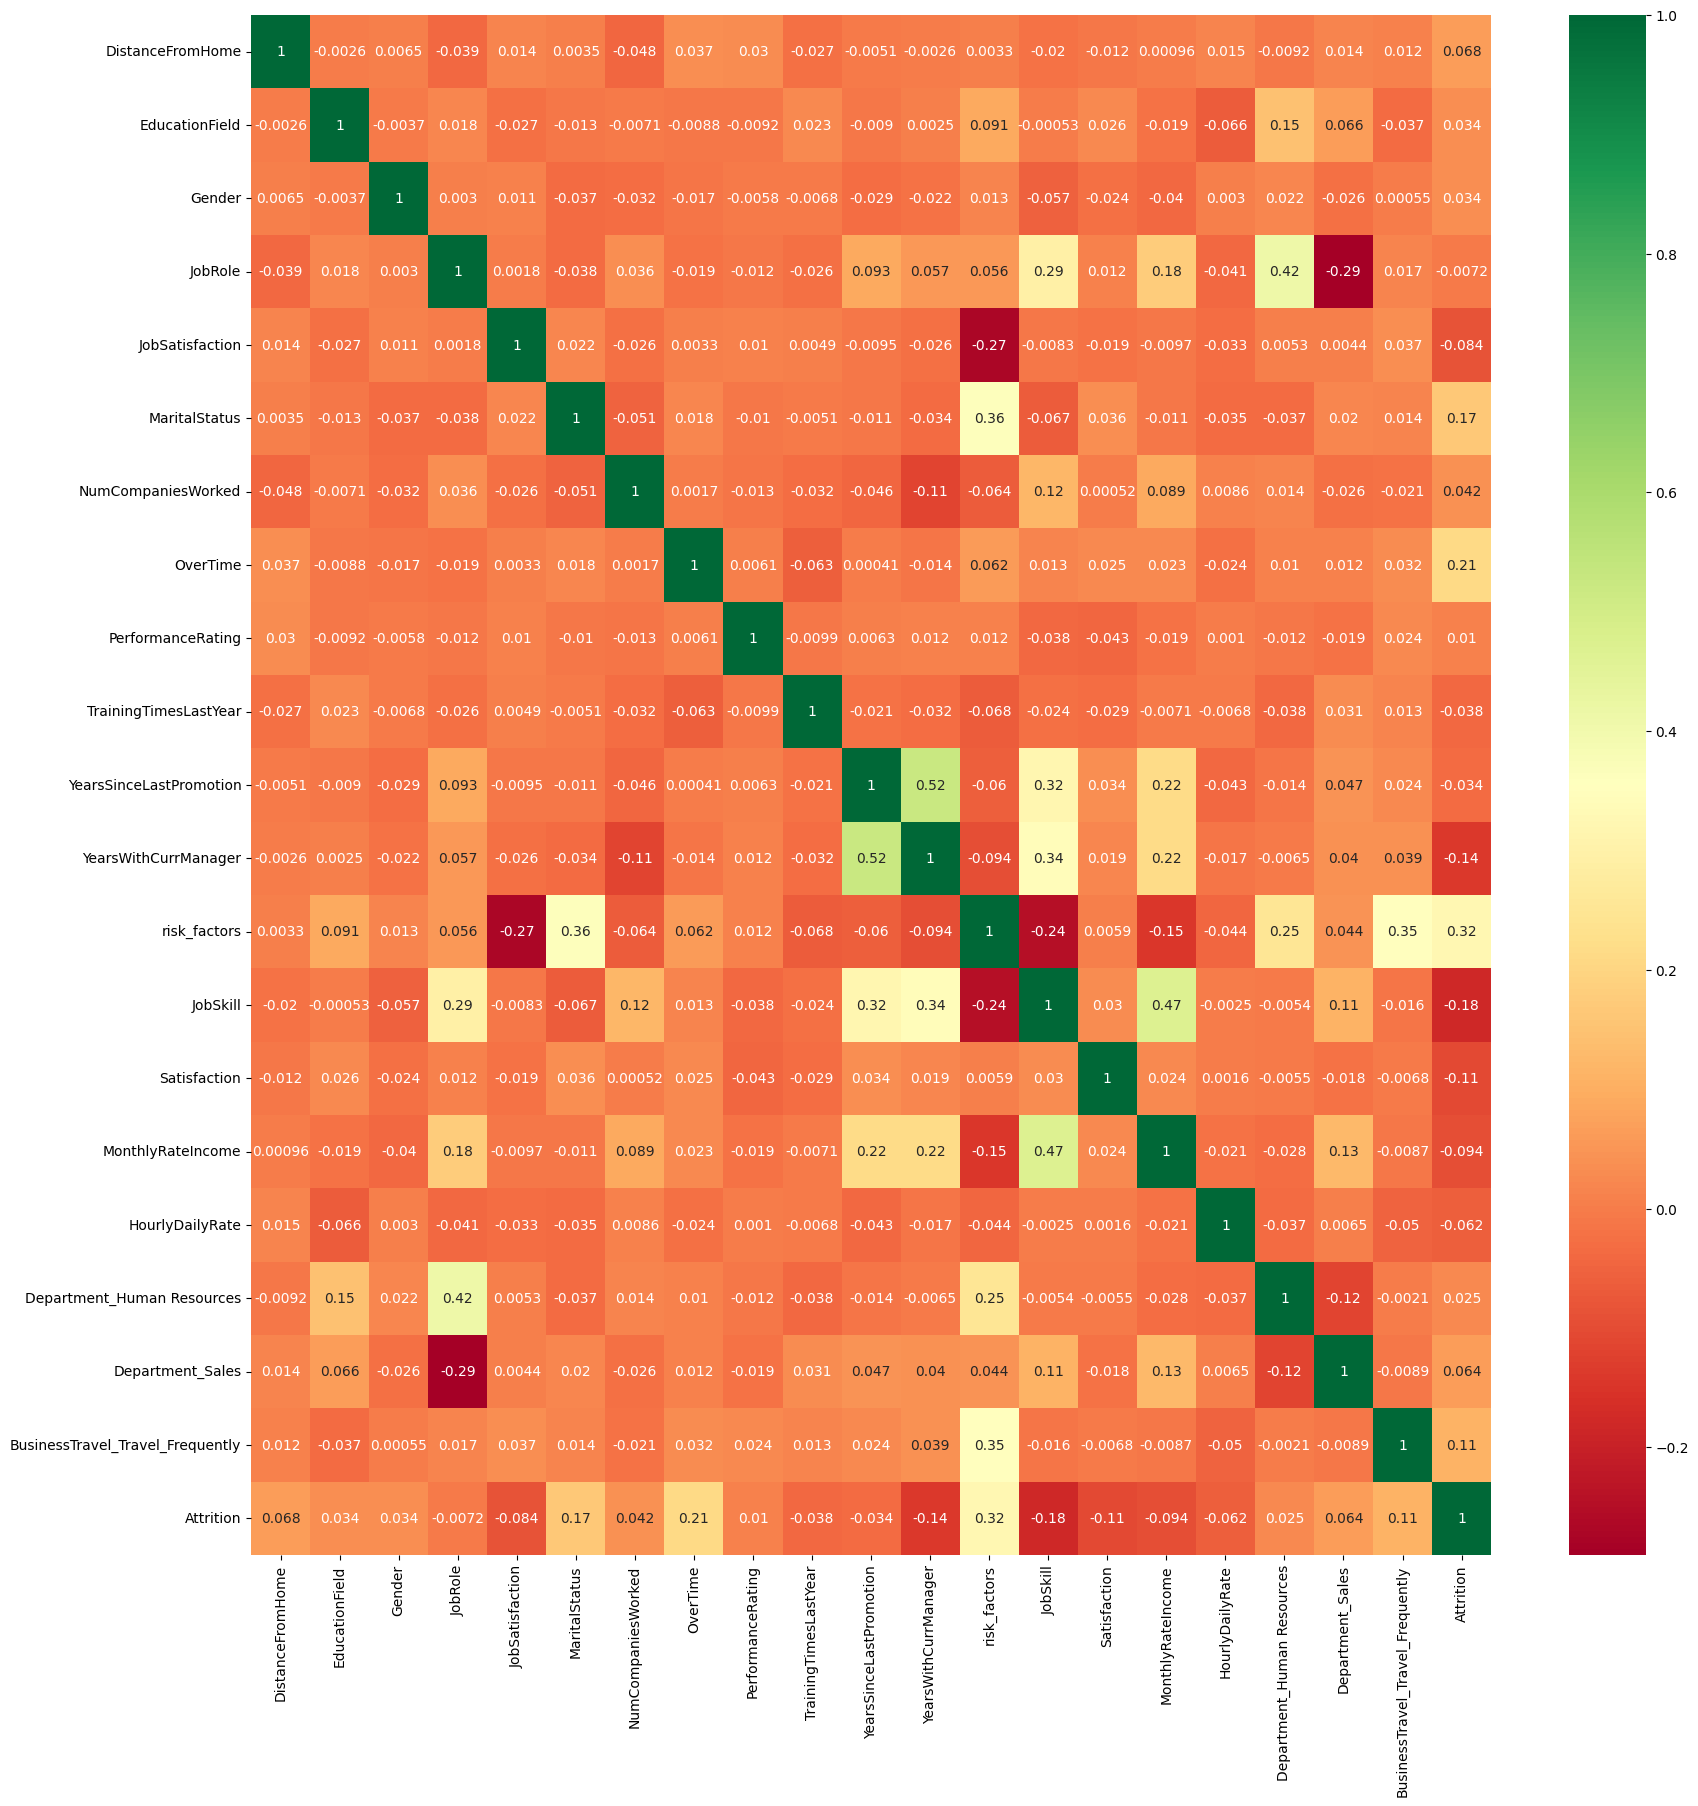

In [24]:
# ploting the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(train[vif_features + [target]].corr(), annot=True, cmap="RdYlGn")
plt.show()

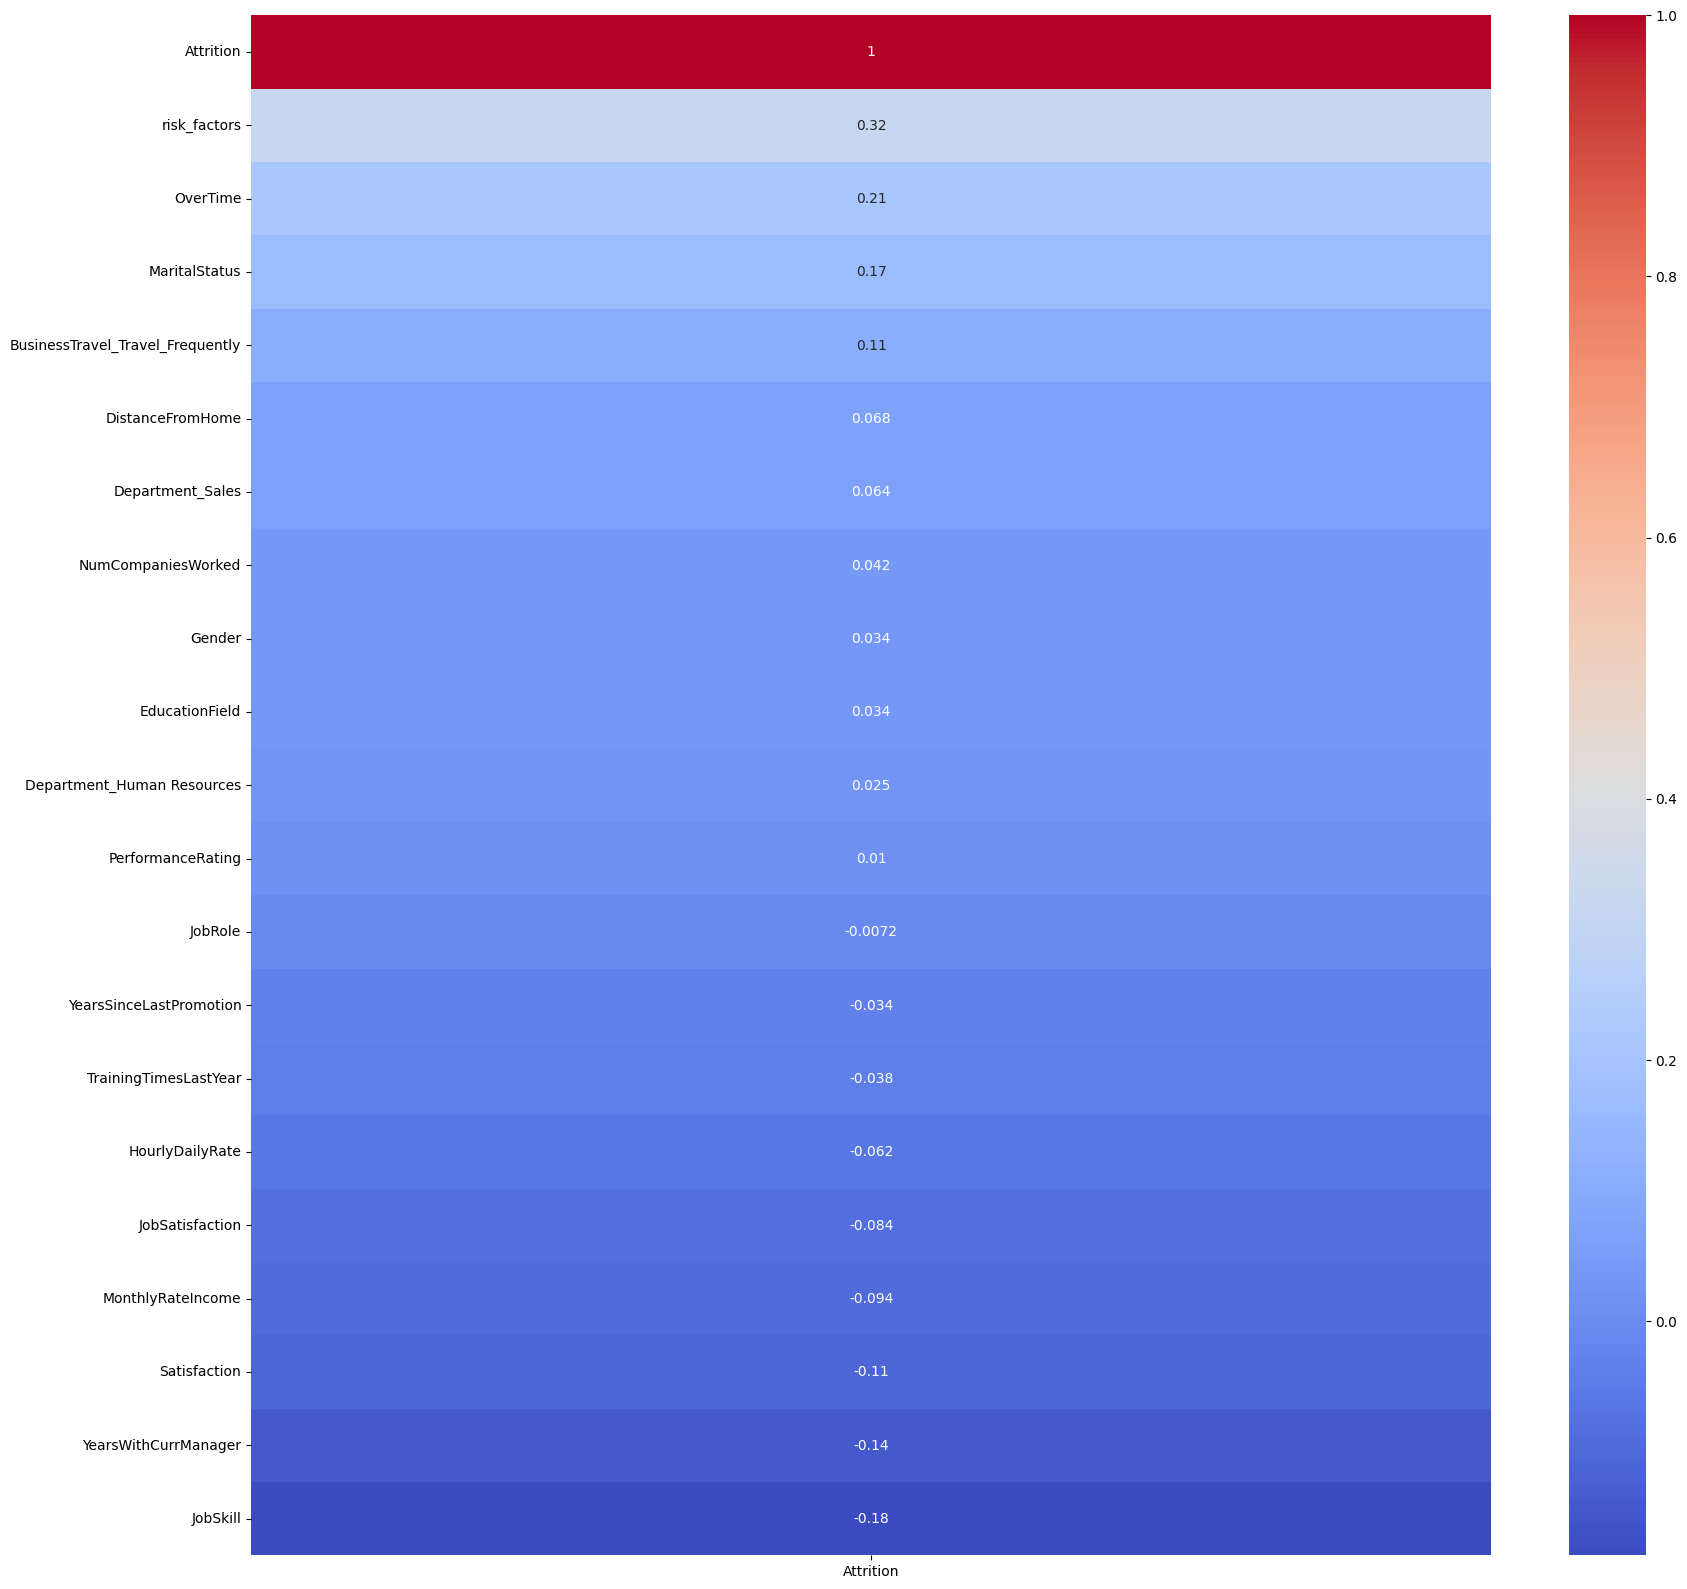

In [25]:
# Plotting the Correlation With Only Attrition Column
plt.figure(figsize=(20, 20))

sns.heatmap(
    train[vif_features+[target]].corr()[[target]].sort_values(by=target, ascending=False),
    annot=True,
    cmap="coolwarm",
)
plt.show()

In [26]:
from sklearn.feature_selection import RFECV

# Step 1: Load your train into X (features) and y (target variable)
X = train.drop(target, axis=1)
X = X[vif_features]
# Features
y = train[target]  # Target variable

# Step 2: Create an instance of the model you want to use for feature selection
estimator = XGBClassifier(random_state=101,verbosity=0,)

# Step 3: Create an instance of the RFE with the desired number of features
rfe = RFECV(estimator,cv=5,scoring='precision',min_features_to_select=5,n_jobs=-1)

# Step 4: Fit the RFE model to your train
rfe.fit(X, y)

# Step 5: Get the selected features
selected_features = X.columns[rfe.support_]

# Print the selected features
print(selected_features)
print(len(selected_features))

Index(['DistanceFromHome', 'EducationField', 'Gender', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'NumCompaniesWorked', 'OverTime',
       'PerformanceRating', 'TrainingTimesLastYear', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'risk_factors', 'JobSkill', 'Satisfaction',
       'MonthlyRateIncome', 'HourlyDailyRate', 'Department_Human Resources',
       'Department_Sales', 'BusinessTravel_Travel_Frequently'],
      dtype='object')
20


In [27]:
# Splitting the data into train and validation set
X = train[list(selected_features)]
y = train[target]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=101, stratify=y
)

# Model Building

In [28]:
# Making a list of tuples containing the model name and the model object.
models = [
    ("Random Forest", RandomForestClassifier(random_state=101,n_jobs=-1)),
    ("XGBoost", XGBClassifier(verbosity=0)),
    ("LightGBM", LGBMClassifier(random_state=101,n_jobs=-1,force_col_wise=True)),
    ("CatBoost", CatBoostClassifier(verbose=0, random_state=101,)),
    ('Extra Trees', ExtraTreesClassifier(random_state=101, n_jobs=-1)),
]

from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

In [29]:
# Creating a dataframe to store the result metrics of each model.
metrics = pd.DataFrame(
    columns=[
        "Model",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
        "ROC_AUC_Score",
        "Cross Validation Score",
    ]
)

# Iterating through the list of models.

for name, model in models:
    # Cross validating the model.
    cv = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy", n_jobs=-1)
    # Appending the metrics to the dataframe.
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred)
    rec = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred)
    # Adding these metrics to the dataframe without appending them to the dataframe.
    metrics.loc[len(metrics)] = [name, acc, prec, rec, f1, roc_auc, np.mean(cv)]
    print("Confusion Matrix for", name)
    print(confusion_matrix(y_valid, y_pred))
    print("--------------------------------------------------")

Confusion Matrix for Random Forest
[[538   5]
 [ 68  19]]
--------------------------------------------------
Confusion Matrix for XGBoost
[[523  20]
 [ 53  34]]
--------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 350, number of negative: 2167
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 2517, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139054 -> initscore=-1.823166
[LightGBM] [Info] Start training from score -1.823166
Confusion Matrix for LightGBM
[[522  21]
 [ 58  29]]
--------------------------------------------------
Confusion Matrix for CatBoost
[[529  14]
 [ 55  32]]
--------------------------------------------------
Confusion Matrix for Extra Trees
[[537   6]
 [ 72  15]]
--------------------------------------------------


In [30]:
metrics.set_index("Model").sort_values(by="Precision", ascending=False)

,Accuracy,Precision,Recall,F1 Score,ROC_AUC_Score,Cross Validation Score
Model,,,,,,
Random Forest,0.884,0.792,0.218,0.342,0.605,0.873
Extra Trees,0.876,0.714,0.172,0.278,0.581,0.874
CatBoost,0.890,0.696,0.368,0.481,0.671,0.881
XGBoost,0.884,0.630,0.391,0.482,0.677,0.870
LightGBM,0.875,0.580,0.333,0.423,0.647,0.874


In [31]:
# Using Smote to balance the data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=101)
X_smote, y_smote = smote.fit_resample(X, y)

# Splitting the data into train and validation set
X_train_smote, X_valid_smote, y_train_smote, y_valid_smote = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=101, stratify=y_smote
)

In [32]:
# Creating a dataframe to store the result smote_metrics of each model.
smote_metrics = pd.DataFrame(
    columns=[
        "Model",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
        "ROC_AUC_Score",
        "Cross Validation Score",
    ]
)

# Iterating through the list of models.

for name, model in models:
    # Cross validating the model.
    cv = cross_val_score(
        model, X_train_smote, y_train_smote, cv=kfold, scoring="accuracy", n_jobs=-1
    )
    # Appending the smote_metrics to the dataframe.
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_valid_smote)
    acc = accuracy_score(y_valid_smote, y_pred)
    prec = precision_score(y_valid_smote, y_pred)
    rec = recall_score(y_valid_smote, y_pred)
    f1 = f1_score(y_valid_smote, y_pred)
    roc_auc = roc_auc_score(y_valid_smote, y_pred)
    smote_metrics.loc[len(smote_metrics)] = [
        name,
        acc,
        prec,
        rec,
        f1,
        roc_auc,
        np.mean(cv),
    ]
    print("Confusion Matrix for", name)
    print(confusion_matrix(y_valid_smote, y_pred))
    print("--------------------------------------------------")

Confusion Matrix for Random Forest
[[492  50]
 [ 42 500]]
--------------------------------------------------
Confusion Matrix for XGBoost
[[496  46]
 [ 38 504]]
--------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2168, number of negative: 2168
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 4336, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Confusion Matrix for LightGBM
[[502  40]
 [ 39 503]]
--------------------------------------------------
Confusion Matrix for CatBoost
[[503  39]
 [ 38 504]]
--------------------------------------------------
Confusion Matrix for Extra Trees
[[485  57]
 [ 45 497]]
--------------------------------------------------


In [33]:
smote_metrics.set_index("Model").sort_values(by="Precision", ascending=False)

,Accuracy,Precision,Recall,F1 Score,ROC_AUC_Score,Cross Validation Score
Model,,,,,,
CatBoost,0.929,0.928,0.930,0.929,0.929,0.910
LightGBM,0.927,0.926,0.928,0.927,0.927,0.909
XGBoost,0.923,0.916,0.930,0.923,0.923,0.912
Random Forest,0.915,0.909,0.923,0.916,0.915,0.885
Extra Trees,0.906,0.897,0.917,0.907,0.906,0.890


In [34]:
# Creating model using best estimator Random Forest Classifier with Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
# Creating a parameter grid to pass in the GridSearchCV.

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
}


# Creating the GridSearchCV object.

grid = GridSearchCV(
    estimator=XGBClassifier(random_state=101, verbosity=0),
    param_grid=param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    cv=kfold,
    verbose=1,
)

# Fitting the GridSearchCV object on the train set.

grid.fit(X_train_smote, y_train_smote)

# Getting the best parameters.

print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
{'gamma': 0.2, 'learning_rate': 0.3, 'min_child_weight': 1}
0.9727985412322016
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=101, ...)


ROC_AUC_Score 0.9197416974169742
Accuracy 0.9197416974169742
Precision 0.9143897996357013
Recall 0.9261992619926199
F1 Score 0.9202566452795602
ROC_AUC_Score 0.9197416974169742
Confusion Matrix
 [[495  47]
 [ 40 502]]


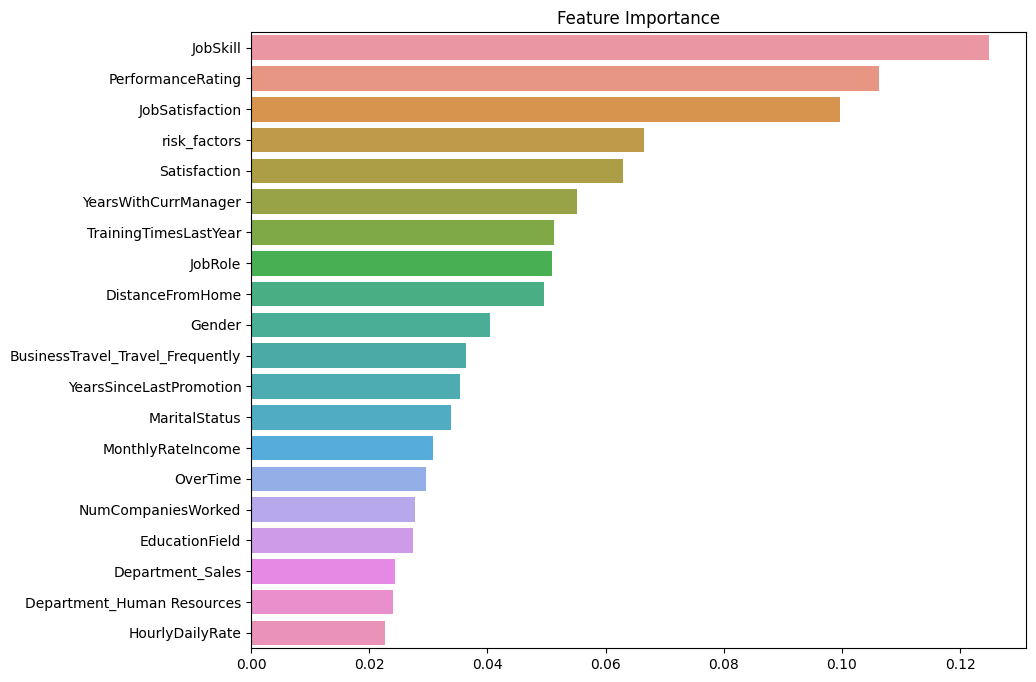

In [35]:
xgb = XGBClassifier(**grid.best_params_)

# Fitting the model on the train set.

xgb.fit(X_train_smote, y_train_smote)

# Predicting the target variable on the train set.

y_pred = xgb.predict(X_valid_smote)

# Getting the roc_auc_score on the train set.

print("ROC_AUC_Score", roc_auc_score(y_valid_smote, y_pred))
print("Accuracy", accuracy_score(y_valid_smote, y_pred))
print("Precision", precision_score(y_valid_smote, y_pred))
print("Recall", recall_score(y_valid_smote, y_pred))
print("F1 Score", f1_score(y_valid_smote, y_pred))
print("ROC_AUC_Score", roc_auc_score(y_valid_smote, y_pred))
print("Confusion Matrix\n", confusion_matrix(y_valid_smote, y_pred))

# Feature Importance

# Zip the feature names with the feature importances and sort them.

imp_features_xgb = sorted(
    zip(selected_features, xgb.feature_importances_), key=lambda x: x[1], reverse=True
)

# Plotting a horizontal barplot.

plt.figure(figsize=(10, 8))
sns.barplot(x=[x[1] for x in imp_features_xgb], y=[x[0] for x in imp_features_xgb])
plt.title("Feature Importance")
plt.show()

# SUMMARY 

- 1. Feature Engineered the data by creating new features like risk_factor, dedication, jobskill, satisfaction, MonthlyRateIncome, DailyHoulryRate of Employee. Applied RFE to get the 15 best features for the model.
- 2. Used Random Forest, XGBoost, LightGBM, CatBoost and took the average of the predictions of all the models to get the final predictions. Also used Hyperparameter Tuning to get the best parameters for the model. Focused on precision of the model as we want to predict the employees who are going to leave the company. Used SMOTE to balance the data increasing the precision of the model from 0.574 to 0.913 with an ROC-AUC score of 0.922.
- 3. 'JobSkill', 'WorkLifeBalance', 'risk_factors', 'YearsWithCurrManager', 'Satisfaction', 'Education', 'DistanceFromHome' are the most important features.

In [43]:
with open("xgb.pkl", "wb") as f:
    pickle.dump(xgb, f)
    pass